# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sign-adjusted topics (BCC) (out of 200 topics estimated on articles published before 2010 using all sources) most correlated with Consumption growth. I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 pre-selected sign-adjusted topics, BCC (<=2009, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function_update

# Define inputs common to all models
q_var = 'Consumption'                     # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual_update.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function_update.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                selected = selected,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function_update.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")
        
        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11854
EM converged at iteration 77, llf=-11587, convergence criterion=9.8551e-07 < tolerance=1e-06
EM start iterations, llf=-11867
EM converged at iteration 77, llf=-11600, convergence criterion=9.8446e-07 < tolerance=1e-06
EM start iterations, llf=-11921
EM converged at iteration 73, llf=-11652, convergence criterion=9.8187e-07 < tolerance=1e-06
EM start iterations, llf=-11928
EM converged at iteration 73, llf=-11659, convergence criterion=9.815e-07 < tolerance=1e-06
EM start iterations, llf=-11991
EM converged at iteration 77, llf=-11716, convergence criterion=9.9626e-07 < tolerance=1e-06
EM start iterations, llf=-11999
EM converged at iteration 77, llf=-11723, convergence criterion=9.9463e-07 < tolerance=1e-06
EM start iterations, llf=-12053
EM converged at iteration 79, llf=-11778, convergence criterion=9.9185e-07 < tolerance=1e-06
EM start iterations, llf=-12053
EM converged at iteration 79, llf=-11778, convergence criterion=9.9185e-07 < tolerance=1e-06
E

EM start iterations, llf=-13550
EM converged at iteration 51, llf=-13328, convergence criterion=9.817e-07 < tolerance=1e-06
EM start iterations, llf=-13610
EM converged at iteration 49, llf=-13399, convergence criterion=9.9733e-07 < tolerance=1e-06
EM start iterations, llf=-13616
EM converged at iteration 49, llf=-13402, convergence criterion=9.9399e-07 < tolerance=1e-06
EM start iterations, llf=-13668
EM converged at iteration 49, llf=-13449, convergence criterion=9.8772e-07 < tolerance=1e-06
EM start iterations, llf=-13668
EM converged at iteration 49, llf=-13449, convergence criterion=9.8772e-07 < tolerance=1e-06
EM start iterations, llf=-13679
EM converged at iteration 50, llf=-13462, convergence criterion=9.6218e-07 < tolerance=1e-06
EM start iterations, llf=-13728
EM converged at iteration 49, llf=-13513, convergence criterion=9.9253e-07 < tolerance=1e-06
EM start iterations, llf=-13733
EM converged at iteration 49, llf=-13517, convergence criterion=9.9854e-07 < tolerance=1e-06
E

EM start iterations, llf=-15291
EM converged at iteration 53, llf=-15054, convergence criterion=9.8345e-07 < tolerance=1e-06
EM start iterations, llf=-15291
EM converged at iteration 53, llf=-15054, convergence criterion=9.8345e-07 < tolerance=1e-06
EM start iterations, llf=-15301
EM converged at iteration 53, llf=-15064, convergence criterion=9.8282e-07 < tolerance=1e-06
EM start iterations, llf=-15356
EM converged at iteration 54, llf=-15119, convergence criterion=9.7204e-07 < tolerance=1e-06
EM start iterations, llf=-15367
EM converged at iteration 54, llf=-15130, convergence criterion=9.6991e-07 < tolerance=1e-06
EM start iterations, llf=-15415
EM converged at iteration 54, llf=-15177, convergence criterion=9.9763e-07 < tolerance=1e-06
EM start iterations, llf=-15423
EM converged at iteration 54, llf=-15184, convergence criterion=9.9616e-07 < tolerance=1e-06
EM start iterations, llf=-15470
EM converged at iteration 54, llf=-15230, convergence criterion=9.8075e-07 < tolerance=1e-06


EM start iterations, llf=-17018
EM converged at iteration 73, llf=-16743, convergence criterion=9.7782e-07 < tolerance=1e-06
EM start iterations, llf=-17022
EM converged at iteration 73, llf=-16748, convergence criterion=9.777e-07 < tolerance=1e-06
EM start iterations, llf=-17075
EM converged at iteration 74, llf=-16800, convergence criterion=9.8424e-07 < tolerance=1e-06
EM start iterations, llf=-17081
EM converged at iteration 74, llf=-16806, convergence criterion=9.841e-07 < tolerance=1e-06
EM start iterations, llf=-17137
EM converged at iteration 74, llf=-16862, convergence criterion=9.9967e-07 < tolerance=1e-06
EM start iterations, llf=-17137
EM converged at iteration 74, llf=-16862, convergence criterion=9.9967e-07 < tolerance=1e-06
EM start iterations, llf=-17146
EM converged at iteration 74, llf=-16872, convergence criterion=9.9849e-07 < tolerance=1e-06
EM start iterations, llf=-17198
EM converged at iteration 75, llf=-16924, convergence criterion=9.8383e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18542
EM converged at iteration 74, llf=-18252, convergence criterion=9.8241e-07 < tolerance=1e-06
EM start iterations, llf=-18599
EM converged at iteration 73, llf=-18307, convergence criterion=9.8764e-07 < tolerance=1e-06
EM start iterations, llf=-18599
EM converged at iteration 73, llf=-18307, convergence criterion=9.8764e-07 < tolerance=1e-06
EM start iterations, llf=-18605
EM converged at iteration 73, llf=-18313, convergence criterion=9.8744e-07 < tolerance=1e-06
EM start iterations, llf=-18657
EM converged at iteration 73, llf=-18363, convergence criterion=9.7893e-07 < tolerance=1e-06
EM start iterations, llf=-18663
EM converged at iteration 73, llf=-18370, convergence criterion=9.7851e-07 < tolerance=1e-06
EM start iterations, llf=-18720
EM converged at iteration 76, llf=-18424, convergence criterion=9.8498e-07 < tolerance=1e-06
EM start iterations, llf=-18728
EM converged at iteration 76, llf=-18432, convergence criterion=9.8468e-07 < tolerance=1e-06


EM converged at iteration 64, llf=-12108, convergence criterion=9.7178e-07 < tolerance=1e-06
EM start iterations, llf=-12382
EM converged at iteration 63, llf=-12088, convergence criterion=9.9726e-07 < tolerance=1e-06
EM start iterations, llf=-12438
EM converged at iteration 93, llf=-12151, convergence criterion=9.8822e-07 < tolerance=1e-06
EM start iterations, llf=-12457
EM converged at iteration 93, llf=-12176, convergence criterion=9.8506e-07 < tolerance=1e-06
EM start iterations, llf=-12517
EM converged at iteration 87, llf=-12257, convergence criterion=9.9924e-07 < tolerance=1e-06
EM start iterations, llf=-12515
EM converged at iteration 87, llf=-12254, convergence criterion=9.9643e-07 < tolerance=1e-06
EM start iterations, llf=-12530
EM converged at iteration 89, llf=-12276, convergence criterion=9.9963e-07 < tolerance=1e-06
EM start iterations, llf=-12530
EM converged at iteration 89, llf=-12276, convergence criterion=9.9963e-07 < tolerance=1e-06
EM start iterations, llf=-12538


EM start iterations, llf=-14086
EM converged at iteration 58, llf=-13856, convergence criterion=9.715e-07 < tolerance=1e-06
EM start iterations, llf=-14125
EM converged at iteration 57, llf=-13886, convergence criterion=9.9888e-07 < tolerance=1e-06
EM start iterations, llf=-14130
EM converged at iteration 58, llf=-13899, convergence criterion=9.9348e-07 < tolerance=1e-06
EM start iterations, llf=-14180
EM converged at iteration 65, llf=-13956, convergence criterion=9.8125e-07 < tolerance=1e-06
EM start iterations, llf=-14180
EM converged at iteration 65, llf=-13956, convergence criterion=9.8125e-07 < tolerance=1e-06
EM start iterations, llf=-14191
EM converged at iteration 65, llf=-13967, convergence criterion=9.8369e-07 < tolerance=1e-06
EM start iterations, llf=-14246
EM converged at iteration 64, llf=-14020, convergence criterion=9.9082e-07 < tolerance=1e-06
EM start iterations, llf=-14253
EM converged at iteration 64, llf=-14027, convergence criterion=9.7877e-07 < tolerance=1e-06
E

EM start iterations, llf=-15849
EM converged at iteration 57, llf=-15598, convergence criterion=9.8464e-07 < tolerance=1e-06
EM start iterations, llf=-15849
EM converged at iteration 57, llf=-15598, convergence criterion=9.8464e-07 < tolerance=1e-06
EM start iterations, llf=-15857
EM converged at iteration 57, llf=-15606, convergence criterion=9.735e-07 < tolerance=1e-06
EM start iterations, llf=-15910
EM converged at iteration 58, llf=-15656, convergence criterion=9.8536e-07 < tolerance=1e-06
EM start iterations, llf=-15912
EM converged at iteration 58, llf=-15658, convergence criterion=9.8747e-07 < tolerance=1e-06
EM start iterations, llf=-15968
EM converged at iteration 58, llf=-15713, convergence criterion=9.8564e-07 < tolerance=1e-06
EM start iterations, llf=-15973
EM converged at iteration 58, llf=-15717, convergence criterion=9.8399e-07 < tolerance=1e-06
EM start iterations, llf=-16017
EM converged at iteration 59, llf=-15762, convergence criterion=9.7868e-07 < tolerance=1e-06
E

EM start iterations, llf=-17573
EM converged at iteration 80, llf=-17303, convergence criterion=9.8388e-07 < tolerance=1e-06
EM start iterations, llf=-17578
EM converged at iteration 80, llf=-17308, convergence criterion=9.8327e-07 < tolerance=1e-06
EM start iterations, llf=-17633
EM converged at iteration 79, llf=-17362, convergence criterion=9.8286e-07 < tolerance=1e-06
EM start iterations, llf=-17641
EM converged at iteration 79, llf=-17368, convergence criterion=9.8058e-07 < tolerance=1e-06
EM start iterations, llf=-17690
EM converged at iteration 78, llf=-17417, convergence criterion=9.9133e-07 < tolerance=1e-06
EM start iterations, llf=-17690
EM converged at iteration 78, llf=-17417, convergence criterion=9.9133e-07 < tolerance=1e-06
EM start iterations, llf=-17709
EM converged at iteration 78, llf=-17436, convergence criterion=9.9091e-07 < tolerance=1e-06
EM start iterations, llf=-17762
EM converged at iteration 77, llf=-17489, convergence criterion=9.8404e-07 < tolerance=1e-06


EM start iterations, llf=-19089
EM converged at iteration 83, llf=-18784, convergence criterion=9.8641e-07 < tolerance=1e-06
EM start iterations, llf=-19139
EM converged at iteration 83, llf=-18835, convergence criterion=9.8334e-07 < tolerance=1e-06
EM start iterations, llf=-19139
EM converged at iteration 83, llf=-18835, convergence criterion=9.8334e-07 < tolerance=1e-06
EM start iterations, llf=-19147
EM converged at iteration 83, llf=-18844, convergence criterion=9.8365e-07 < tolerance=1e-06
EM start iterations, llf=-19205
EM converged at iteration 83, llf=-18901, convergence criterion=9.8247e-07 < tolerance=1e-06
EM start iterations, llf=-19212
EM converged at iteration 83, llf=-18909, convergence criterion=9.8189e-07 < tolerance=1e-06
EM start iterations, llf=-19265
EM converged at iteration 82, llf=-18961, convergence criterion=9.8165e-07 < tolerance=1e-06
EM start iterations, llf=-19274
EM converged at iteration 82, llf=-18969, convergence criterion=9.8077e-07 < tolerance=1e-06


EM start iterations, llf=-12873
EM converged at iteration 67, llf=-12631, convergence criterion=9.9268e-07 < tolerance=1e-06
EM start iterations, llf=-12878
EM converged at iteration 67, llf=-12637, convergence criterion=9.9175e-07 < tolerance=1e-06
EM start iterations, llf=-12930
EM converged at iteration 68, llf=-12687, convergence criterion=9.7708e-07 < tolerance=1e-06
EM start iterations, llf=-12937
EM converged at iteration 68, llf=-12694, convergence criterion=9.7757e-07 < tolerance=1e-06
EM start iterations, llf=-12978
EM converged at iteration 65, llf=-12730, convergence criterion=9.909e-07 < tolerance=1e-06
EM start iterations, llf=-12988
EM converged at iteration 65, llf=-12740, convergence criterion=9.8639e-07 < tolerance=1e-06
EM start iterations, llf=-13050
EM converged at iteration 66, llf=-12810, convergence criterion=9.989e-07 < tolerance=1e-06
EM start iterations, llf=-13050
EM converged at iteration 66, llf=-12810, convergence criterion=9.989e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-14615
EM converged at iteration 64, llf=-14385, convergence criterion=9.8852e-07 < tolerance=1e-06
EM start iterations, llf=-14674
EM converged at iteration 65, llf=-14447, convergence criterion=9.7177e-07 < tolerance=1e-06
EM start iterations, llf=-14682
EM converged at iteration 64, llf=-14452, convergence criterion=9.9448e-07 < tolerance=1e-06
EM start iterations, llf=-14739
EM converged at iteration 64, llf=-14510, convergence criterion=9.9443e-07 < tolerance=1e-06
EM start iterations, llf=-14739
EM converged at iteration 64, llf=-14510, convergence criterion=9.9443e-07 < tolerance=1e-06
EM start iterations, llf=-14746
EM converged at iteration 64, llf=-14517, convergence criterion=9.8711e-07 < tolerance=1e-06
EM start iterations, llf=-14800
EM converged at iteration 64, llf=-14570, convergence criterion=9.8693e-07 < tolerance=1e-06
EM start iterations, llf=-14809
EM converged at iteration 64, llf=-14577, convergence criterion=9.7436e-07 < tolerance=1e-06


EM start iterations, llf=-16398
EM converged at iteration 72, llf=-16141, convergence criterion=9.9555e-07 < tolerance=1e-06
EM start iterations, llf=-16398
EM converged at iteration 72, llf=-16141, convergence criterion=9.9555e-07 < tolerance=1e-06
EM start iterations, llf=-16407
EM converged at iteration 72, llf=-16149, convergence criterion=9.9377e-07 < tolerance=1e-06
EM start iterations, llf=-16462
EM converged at iteration 76, llf=-16202, convergence criterion=9.9463e-07 < tolerance=1e-06
EM start iterations, llf=-16471
EM converged at iteration 76, llf=-16212, convergence criterion=9.9352e-07 < tolerance=1e-06
EM start iterations, llf=-16521
EM converged at iteration 77, llf=-16262, convergence criterion=9.9202e-07 < tolerance=1e-06
EM start iterations, llf=-16529
EM converged at iteration 77, llf=-16269, convergence criterion=9.9029e-07 < tolerance=1e-06
EM start iterations, llf=-16583
EM converged at iteration 77, llf=-16322, convergence criterion=9.8706e-07 < tolerance=1e-06


EM start iterations, llf=-17867
EM converged at iteration 99, llf=-17590, convergence criterion=9.9952e-07 < tolerance=1e-06
EM start iterations, llf=-17867
EM converged at iteration 99, llf=-17590, convergence criterion=9.9952e-07 < tolerance=1e-06
EM start iterations, llf=-17877
EM converged at iteration 99, llf=-17601, convergence criterion=9.9992e-07 < tolerance=1e-06
EM start iterations, llf=-17927
EM converged at iteration 98, llf=-17649, convergence criterion=9.9531e-07 < tolerance=1e-06
EM start iterations, llf=-17934
EM converged at iteration 98, llf=-17655, convergence criterion=9.9476e-07 < tolerance=1e-06
EM start iterations, llf=-17991
EM converged at iteration 96, llf=-17711, convergence criterion=9.9546e-07 < tolerance=1e-06
EM start iterations, llf=-17999
EM converged at iteration 96, llf=-17719, convergence criterion=9.9522e-07 < tolerance=1e-06
EM start iterations, llf=-18054
EM converged at iteration 96, llf=-17774, convergence criterion=9.949e-07 < tolerance=1e-06
E

EM start iterations, llf=-19080
EM converged at iteration 99, llf=-18775, convergence criterion=9.8984e-07 < tolerance=1e-06
EM start iterations, llf=-19130
EM converged at iteration 98, llf=-18827, convergence criterion=9.9738e-07 < tolerance=1e-06
EM start iterations, llf=-19130
EM converged at iteration 98, llf=-18827, convergence criterion=9.9738e-07 < tolerance=1e-06
EM start iterations, llf=-19138
EM converged at iteration 98, llf=-18836, convergence criterion=9.9716e-07 < tolerance=1e-06
EM start iterations, llf=-19195
EM converged at iteration 98, llf=-18893, convergence criterion=9.9274e-07 < tolerance=1e-06
EM start iterations, llf=-19203
EM converged at iteration 98, llf=-18900, convergence criterion=9.9219e-07 < tolerance=1e-06
EM start iterations, llf=-19256
EM converged at iteration 96, llf=-18952, convergence criterion=9.9454e-07 < tolerance=1e-06
EM start iterations, llf=-19265
EM converged at iteration 96, llf=-18961, convergence criterion=9.9389e-07 < tolerance=1e-06


EM start iterations, llf=-12240
EM converged at iteration 52, llf=-12065, convergence criterion=9.8897e-07 < tolerance=1e-06
EM start iterations, llf=-12257
EM converged at iteration 52, llf=-12077, convergence criterion=9.8495e-07 < tolerance=1e-06
EM start iterations, llf=-12303
EM converged at iteration 52, llf=-12123, convergence criterion=9.7909e-07 < tolerance=1e-06
EM start iterations, llf=-12303
EM converged at iteration 52, llf=-12123, convergence criterion=9.7909e-07 < tolerance=1e-06
EM start iterations, llf=-12303
EM converged at iteration 52, llf=-12125, convergence criterion=9.909e-07 < tolerance=1e-06
EM start iterations, llf=-12344
EM converged at iteration 53, llf=-12169, convergence criterion=9.8307e-07 < tolerance=1e-06
EM start iterations, llf=-12355
EM converged at iteration 53, llf=-12178, convergence criterion=9.6942e-07 < tolerance=1e-06
EM start iterations, llf=-12398
EM converged at iteration 50, llf=-12224, convergence criterion=9.6679e-07 < tolerance=1e-06
E

EM start iterations, llf=-13845
EM converged at iteration 50, llf=-13659, convergence criterion=9.9248e-07 < tolerance=1e-06
EM start iterations, llf=-13852
EM converged at iteration 50, llf=-13665, convergence criterion=9.879e-07 < tolerance=1e-06
EM start iterations, llf=-13914
EM converged at iteration 50, llf=-13726, convergence criterion=9.7477e-07 < tolerance=1e-06
EM start iterations, llf=-13920
EM converged at iteration 50, llf=-13732, convergence criterion=9.7659e-07 < tolerance=1e-06
EM start iterations, llf=-13974
EM converged at iteration 51, llf=-13787, convergence criterion=9.6855e-07 < tolerance=1e-06
EM start iterations, llf=-13983
EM converged at iteration 51, llf=-13796, convergence criterion=9.6998e-07 < tolerance=1e-06
EM start iterations, llf=-14038
EM converged at iteration 50, llf=-13849, convergence criterion=9.9509e-07 < tolerance=1e-06
EM start iterations, llf=-14038
EM converged at iteration 50, llf=-13849, convergence criterion=9.9509e-07 < tolerance=1e-06
E

EM start iterations, llf=-15531
EM converged at iteration 58, llf=-15335, convergence criterion=9.7573e-07 < tolerance=1e-06
EM start iterations, llf=-15587
EM converged at iteration 58, llf=-15389, convergence criterion=9.8925e-07 < tolerance=1e-06
EM start iterations, llf=-15592
EM converged at iteration 58, llf=-15394, convergence criterion=9.9023e-07 < tolerance=1e-06
EM start iterations, llf=-15648
EM converged at iteration 59, llf=-15450, convergence criterion=9.7424e-07 < tolerance=1e-06
EM start iterations, llf=-15648
EM converged at iteration 59, llf=-15450, convergence criterion=9.7424e-07 < tolerance=1e-06
EM start iterations, llf=-15658
EM converged at iteration 59, llf=-15460, convergence criterion=9.7353e-07 < tolerance=1e-06
EM start iterations, llf=-15710
EM converged at iteration 61, llf=-15513, convergence criterion=9.7444e-07 < tolerance=1e-06
EM start iterations, llf=-15719
EM converged at iteration 60, llf=-15521, convergence criterion=9.9982e-07 < tolerance=1e-06


EM start iterations, llf=-17241
EM converged at iteration 77, llf=-17031, convergence criterion=9.8125e-07 < tolerance=1e-06
EM start iterations, llf=-17241
EM converged at iteration 77, llf=-17031, convergence criterion=9.8125e-07 < tolerance=1e-06
EM start iterations, llf=-17248
EM converged at iteration 77, llf=-17038, convergence criterion=9.8239e-07 < tolerance=1e-06
EM start iterations, llf=-17296
EM converged at iteration 78, llf=-17085, convergence criterion=9.8356e-07 < tolerance=1e-06
EM start iterations, llf=-17303
EM converged at iteration 78, llf=-17091, convergence criterion=9.8197e-07 < tolerance=1e-06
EM start iterations, llf=-17354
EM converged at iteration 77, llf=-17141, convergence criterion=9.9052e-07 < tolerance=1e-06
EM start iterations, llf=-17362
EM converged at iteration 77, llf=-17149, convergence criterion=9.9117e-07 < tolerance=1e-06
EM start iterations, llf=-17415
EM converged at iteration 78, llf=-17201, convergence criterion=9.8212e-07 < tolerance=1e-06


EM start iterations, llf=-18404
EM converged at iteration 81, llf=-18188, convergence criterion=9.8212e-07 < tolerance=1e-06
EM start iterations, llf=-18415
EM converged at iteration 81, llf=-18199, convergence criterion=9.8166e-07 < tolerance=1e-06
EM start iterations, llf=-18470
EM converged at iteration 80, llf=-18254, convergence criterion=9.8096e-07 < tolerance=1e-06
EM start iterations, llf=-18474
EM converged at iteration 80, llf=-18258, convergence criterion=9.8065e-07 < tolerance=1e-06
EM start iterations, llf=-18527
EM converged at iteration 80, llf=-18311, convergence criterion=9.8187e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 1 estimated in 2:45:17.698955.
EM start iterations, llf=-11371
EM converged at iteration 92, llf=-11202, convergence criterion=9.9803e-07 < tolerance=1e-06
EM start iterations, llf=-11383
EM converged at iteration 92, llf=-11214, convergence criterion=9.9369e-07 < tolerance=1e-06
EM start iterations, llf=-11437
EM converged at

EM start iterations, llf=-12695
EM converged at iteration 65, llf=-12522, convergence criterion=9.8328e-07 < tolerance=1e-06
EM start iterations, llf=-12741
EM converged at iteration 69, llf=-12569, convergence criterion=9.9921e-07 < tolerance=1e-06
EM start iterations, llf=-12792
EM converged at iteration 70, llf=-12617, convergence criterion=9.9123e-07 < tolerance=1e-06
EM start iterations, llf=-12828
EM converged at iteration 70, llf=-12655, convergence criterion=9.9492e-07 < tolerance=1e-06
EM start iterations, llf=-12828
EM converged at iteration 70, llf=-12655, convergence criterion=9.9492e-07 < tolerance=1e-06
EM start iterations, llf=-12841
EM converged at iteration 70, llf=-12668, convergence criterion=9.9603e-07 < tolerance=1e-06
EM start iterations, llf=-12877
EM converged at iteration 71, llf=-12703, convergence criterion=9.9872e-07 < tolerance=1e-06
EM start iterations, llf=-12884
EM converged at iteration 72, llf=-12707, convergence criterion=9.8483e-07 < tolerance=1e-06


EM start iterations, llf=-14385
EM converged at iteration 59, llf=-14195, convergence criterion=9.7871e-07 < tolerance=1e-06
EM start iterations, llf=-14385
EM converged at iteration 59, llf=-14195, convergence criterion=9.7871e-07 < tolerance=1e-06
EM start iterations, llf=-14390
EM converged at iteration 59, llf=-14201, convergence criterion=9.7267e-07 < tolerance=1e-06
EM start iterations, llf=-14437
EM converged at iteration 58, llf=-14250, convergence criterion=9.9315e-07 < tolerance=1e-06
EM start iterations, llf=-14449
EM converged at iteration 59, llf=-14260, convergence criterion=9.7665e-07 < tolerance=1e-06
EM start iterations, llf=-14501
EM converged at iteration 61, llf=-14312, convergence criterion=9.8496e-07 < tolerance=1e-06
EM start iterations, llf=-14509
EM converged at iteration 61, llf=-14320, convergence criterion=9.8367e-07 < tolerance=1e-06
EM start iterations, llf=-14559
EM converged at iteration 60, llf=-14369, convergence criterion=9.9855e-07 < tolerance=1e-06


EM start iterations, llf=-16044
EM converged at iteration 80, llf=-15843, convergence criterion=9.966e-07 < tolerance=1e-06
EM start iterations, llf=-16051
EM converged at iteration 80, llf=-15849, convergence criterion=9.9307e-07 < tolerance=1e-06
EM start iterations, llf=-16105
EM converged at iteration 78, llf=-15903, convergence criterion=9.891e-07 < tolerance=1e-06
EM start iterations, llf=-16114
EM converged at iteration 78, llf=-15912, convergence criterion=9.9079e-07 < tolerance=1e-06
EM start iterations, llf=-16157
EM converged at iteration 78, llf=-15956, convergence criterion=9.9225e-07 < tolerance=1e-06
EM start iterations, llf=-16157
EM converged at iteration 78, llf=-15956, convergence criterion=9.9225e-07 < tolerance=1e-06
EM start iterations, llf=-16171
EM converged at iteration 78, llf=-15969, convergence criterion=9.9129e-07 < tolerance=1e-06
EM start iterations, llf=-16228
EM converged at iteration 79, llf=-16027, convergence criterion=9.8892e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17711
EM converged at iteration 88, llf=-17496, convergence criterion=9.8395e-07 < tolerance=1e-06
EM start iterations, llf=-17554
EM converged at iteration 88, llf=-17345, convergence criterion=9.8912e-07 < tolerance=1e-06
EM start iterations, llf=-17554
EM converged at iteration 88, llf=-17345, convergence criterion=9.8912e-07 < tolerance=1e-06
EM start iterations, llf=-17560
EM converged at iteration 88, llf=-17351, convergence criterion=9.9056e-07 < tolerance=1e-06
EM start iterations, llf=-17609
EM converged at iteration 85, llf=-17399, convergence criterion=9.9506e-07 < tolerance=1e-06
EM start iterations, llf=-17623
EM converged at iteration 85, llf=-17412, convergence criterion=9.9644e-07 < tolerance=1e-06
EM start iterations, llf=-17680
EM converged at iteration 82, llf=-17468, convergence criterion=9.8415e-07 < tolerance=1e-06
EM start iterations, llf=-17686
EM converged at iteration 82, llf=-17474, convergence criterion=9.8552e-07 < tolerance=1e-06


EM start iterations, llf=-11714
EM converged at iteration 72, llf=-11535, convergence criterion=9.7928e-07 < tolerance=1e-06
EM start iterations, llf=-11723
EM converged at iteration 74, llf=-11545, convergence criterion=9.9803e-07 < tolerance=1e-06
EM start iterations, llf=-11764
EM converged at iteration 80, llf=-11589, convergence criterion=9.8403e-07 < tolerance=1e-06
EM start iterations, llf=-11775
EM converged at iteration 75, llf=-11599, convergence criterion=9.9441e-07 < tolerance=1e-06
EM start iterations, llf=-11811
EM converged at iteration 72, llf=-11638, convergence criterion=9.9921e-07 < tolerance=1e-06
EM start iterations, llf=-11814
EM converged at iteration 77, llf=-11639, convergence criterion=9.843e-07 < tolerance=1e-06
EM start iterations, llf=-11881
EM converged at iteration 81, llf=-11706, convergence criterion=9.9495e-07 < tolerance=1e-06
EM start iterations, llf=-11881
EM converged at iteration 81, llf=-11706, convergence criterion=9.9495e-07 < tolerance=1e-06
E

EM start iterations, llf=-13228
EM converged at iteration 76, llf=-13043, convergence criterion=9.8697e-07 < tolerance=1e-06
EM start iterations, llf=-13274
EM converged at iteration 76, llf=-13088, convergence criterion=9.7977e-07 < tolerance=1e-06
EM start iterations, llf=-13282
EM converged at iteration 76, llf=-13096, convergence criterion=9.816e-07 < tolerance=1e-06
EM start iterations, llf=-13326
EM converged at iteration 75, llf=-13138, convergence criterion=9.9567e-07 < tolerance=1e-06
EM start iterations, llf=-13326
EM converged at iteration 75, llf=-13138, convergence criterion=9.9567e-07 < tolerance=1e-06
EM start iterations, llf=-13335
EM converged at iteration 76, llf=-13149, convergence criterion=9.7747e-07 < tolerance=1e-06
EM start iterations, llf=-13380
EM converged at iteration 76, llf=-13194, convergence criterion=9.9351e-07 < tolerance=1e-06
EM start iterations, llf=-13388
EM converged at iteration 77, llf=-13202, convergence criterion=9.8652e-07 < tolerance=1e-06
E

EM start iterations, llf=-14909
EM converged at iteration 70, llf=-14717, convergence criterion=9.9544e-07 < tolerance=1e-06
EM start iterations, llf=-14909
EM converged at iteration 70, llf=-14717, convergence criterion=9.9544e-07 < tolerance=1e-06
EM start iterations, llf=-14922
EM converged at iteration 70, llf=-14729, convergence criterion=9.9659e-07 < tolerance=1e-06
EM start iterations, llf=-14974
EM converged at iteration 69, llf=-14781, convergence criterion=9.8891e-07 < tolerance=1e-06
EM start iterations, llf=-14983
EM converged at iteration 69, llf=-14790, convergence criterion=9.9139e-07 < tolerance=1e-06
EM start iterations, llf=-15034
EM converged at iteration 68, llf=-14841, convergence criterion=9.7703e-07 < tolerance=1e-06
EM start iterations, llf=-15041
EM converged at iteration 68, llf=-14848, convergence criterion=9.8174e-07 < tolerance=1e-06
EM start iterations, llf=-15086
EM converged at iteration 69, llf=-14896, convergence criterion=9.7453e-07 < tolerance=1e-06


EM converged at iteration 131, llf=-16129, convergence criterion=9.9803e-07 < tolerance=1e-06
EM start iterations, llf=-16341
EM iteration 100, llf=-16138, convergence criterion=1.1666e-06
EM converged at iteration 130, llf=-16137, convergence criterion=9.9937e-07 < tolerance=1e-06
EM start iterations, llf=-16393
EM iteration 100, llf=-16188, convergence criterion=1.1989e-06
EM iteration 200, llf=-16187, convergence criterion=1.022e-06
EM converged at iteration 246, llf=-16186, convergence criterion=9.9989e-07 < tolerance=1e-06
EM start iterations, llf=-16403
EM iteration 100, llf=-16198, convergence criterion=1.2007e-06
EM iteration 200, llf=-16197, convergence criterion=1.0227e-06
EM converged at iteration 247, llf=-16196, convergence criterion=9.9897e-07 < tolerance=1e-06
EM start iterations, llf=-16450
EM iteration 100, llf=-16245, convergence criterion=1.1783e-06
EM converged at iteration 134, llf=-16245, convergence criterion=9.9822e-07 < tolerance=1e-06
EM start iterations, llf=

EM start iterations, llf=-17286
EM iteration 100, llf=-17073, convergence criterion=1.2177e-06
EM converged at iteration 139, llf=-17073, convergence criterion=9.9866e-07 < tolerance=1e-06
EM start iterations, llf=-17337
EM iteration 100, llf=-17123, convergence criterion=1.212e-06
EM converged at iteration 137, llf=-17123, convergence criterion=9.9782e-07 < tolerance=1e-06
EM start iterations, llf=-17345
EM iteration 100, llf=-17131, convergence criterion=1.2131e-06
EM converged at iteration 137, llf=-17130, convergence criterion=9.9807e-07 < tolerance=1e-06
EM start iterations, llf=-17398
EM iteration 100, llf=-17184, convergence criterion=1.2212e-06
EM converged at iteration 136, llf=-17183, convergence criterion=9.9805e-07 < tolerance=1e-06
EM start iterations, llf=-17398
EM iteration 100, llf=-17184, convergence criterion=1.2212e-06
EM converged at iteration 136, llf=-17183, convergence criterion=9.9805e-07 < tolerance=1e-06
EM start iterations, llf=-17403
EM iteration 100, llf=-1

EM start iterations, llf=-18150
EM iteration 100, llf=-17931, convergence criterion=1.167e-06
EM converged at iteration 119, llf=-17931, convergence criterion=9.9383e-07 < tolerance=1e-06
EM start iterations, llf=-18198
EM iteration 100, llf=-17980, convergence criterion=1.1811e-06
EM converged at iteration 121, llf=-17980, convergence criterion=9.9416e-07 < tolerance=1e-06
EM start iterations, llf=-18205
EM iteration 100, llf=-17987, convergence criterion=1.1771e-06
EM converged at iteration 120, llf=-17986, convergence criterion=9.9716e-07 < tolerance=1e-06
EM start iterations, llf=-18252
EM iteration 100, llf=-18032, convergence criterion=1.1745e-06
EM converged at iteration 119, llf=-18032, convergence criterion=9.9996e-07 < tolerance=1e-06
EM start iterations, llf=-18252
EM iteration 100, llf=-18032, convergence criterion=1.1745e-06
EM converged at iteration 119, llf=-18032, convergence criterion=9.9996e-07 < tolerance=1e-06
EM start iterations, llf=-18257
EM iteration 100, llf=-1

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


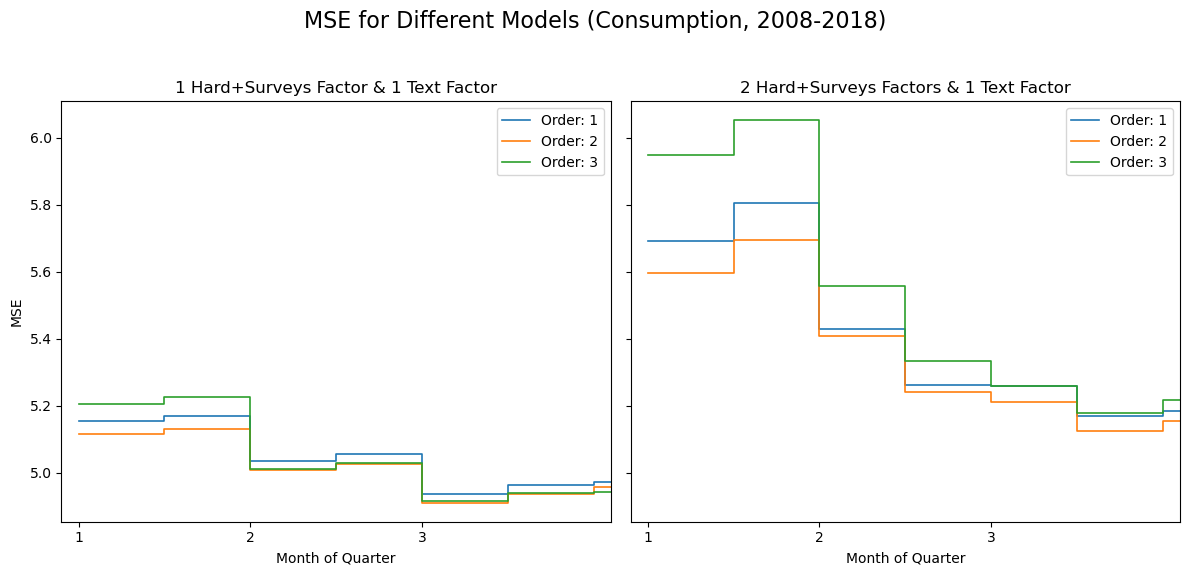

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


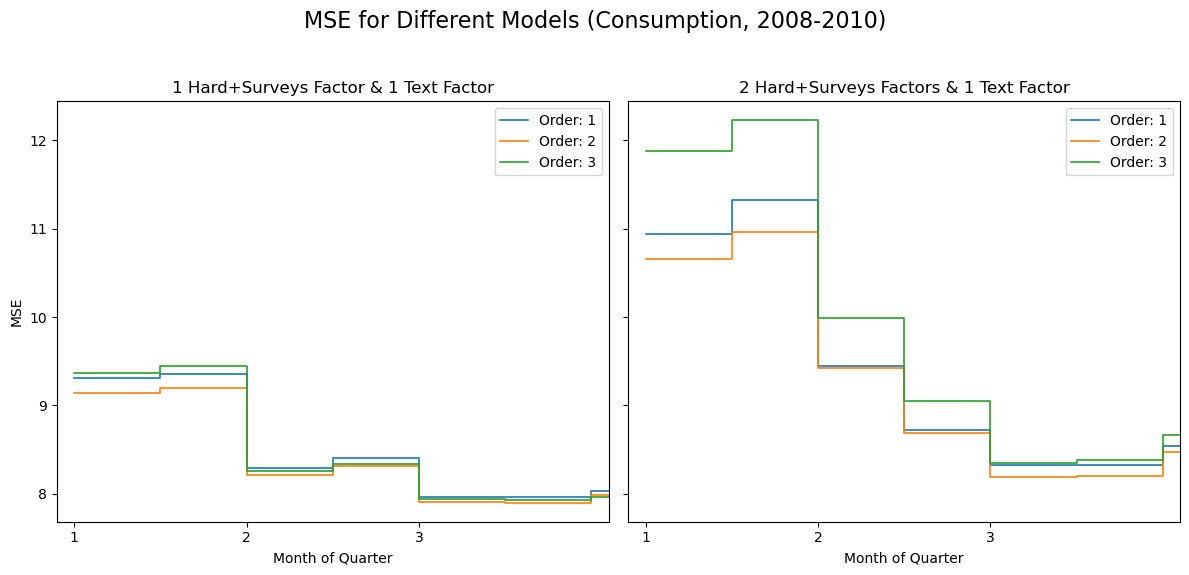

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


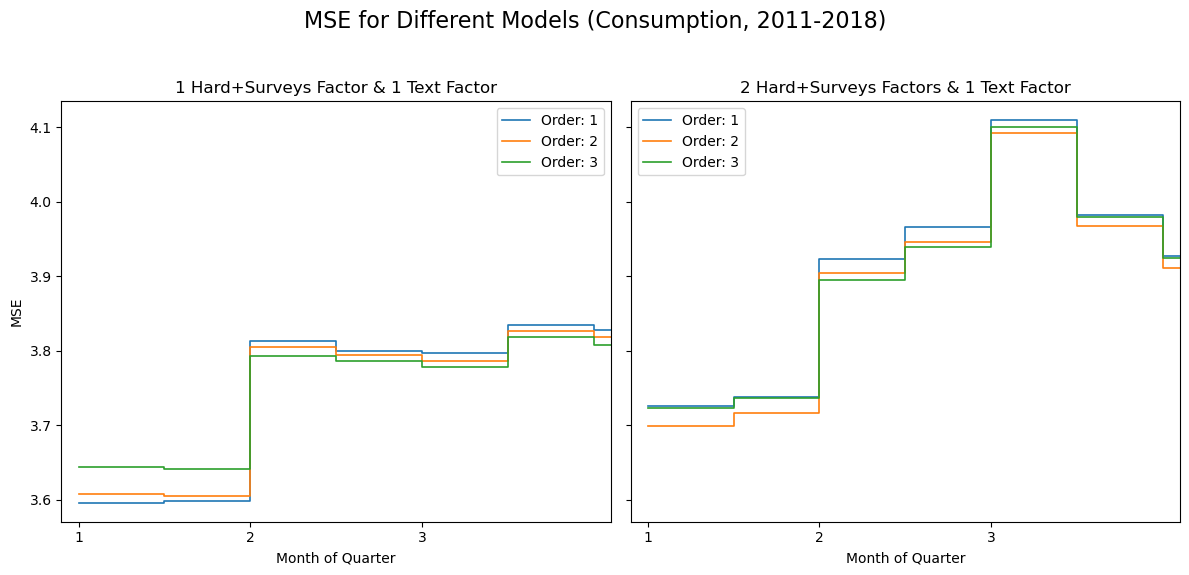

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


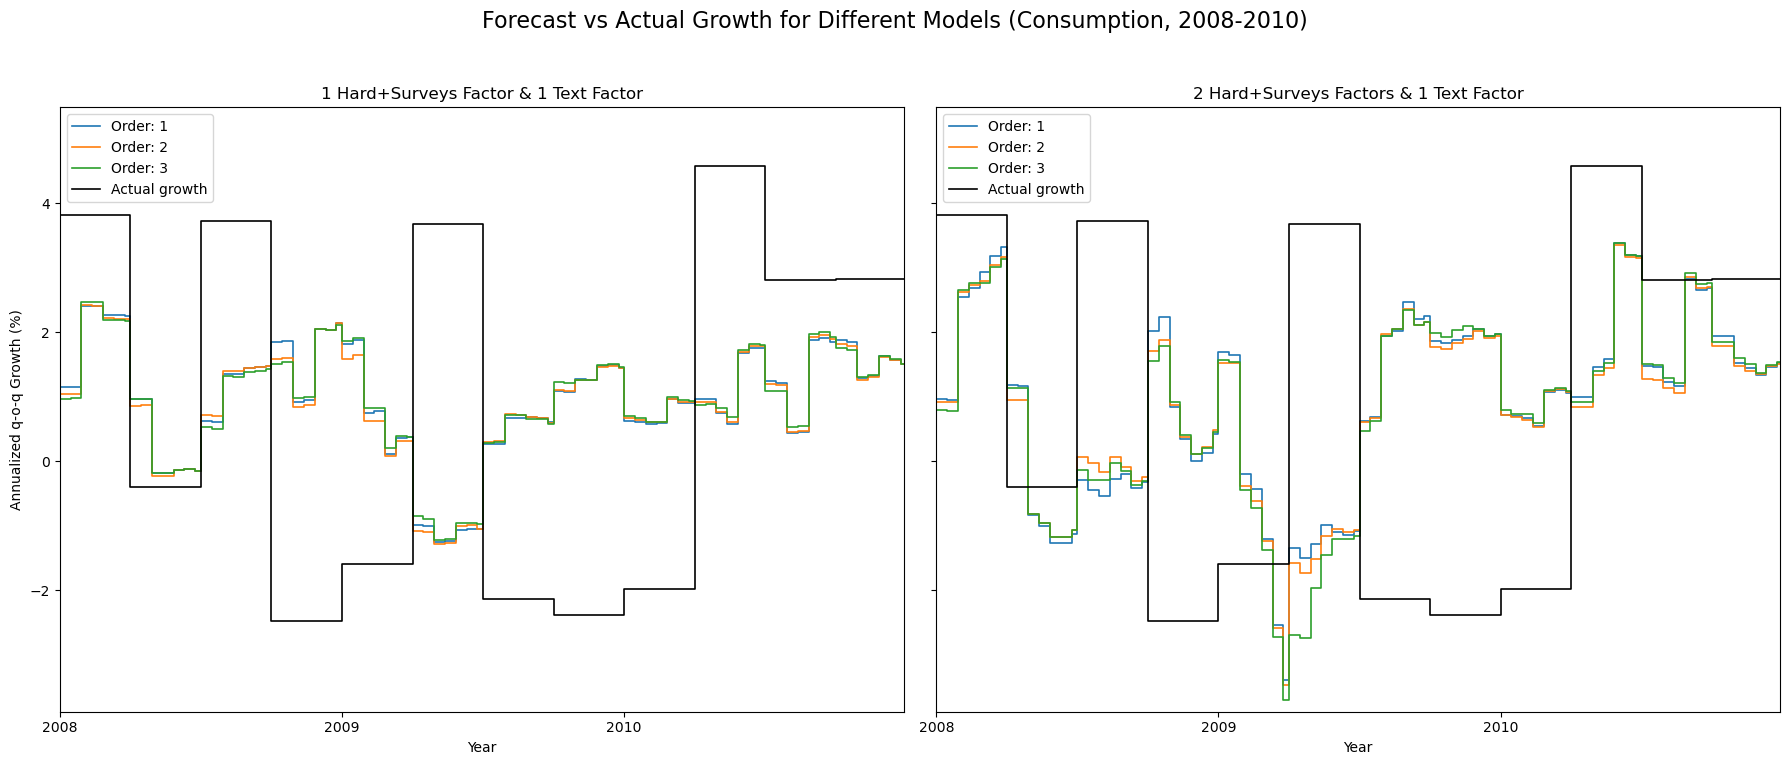

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


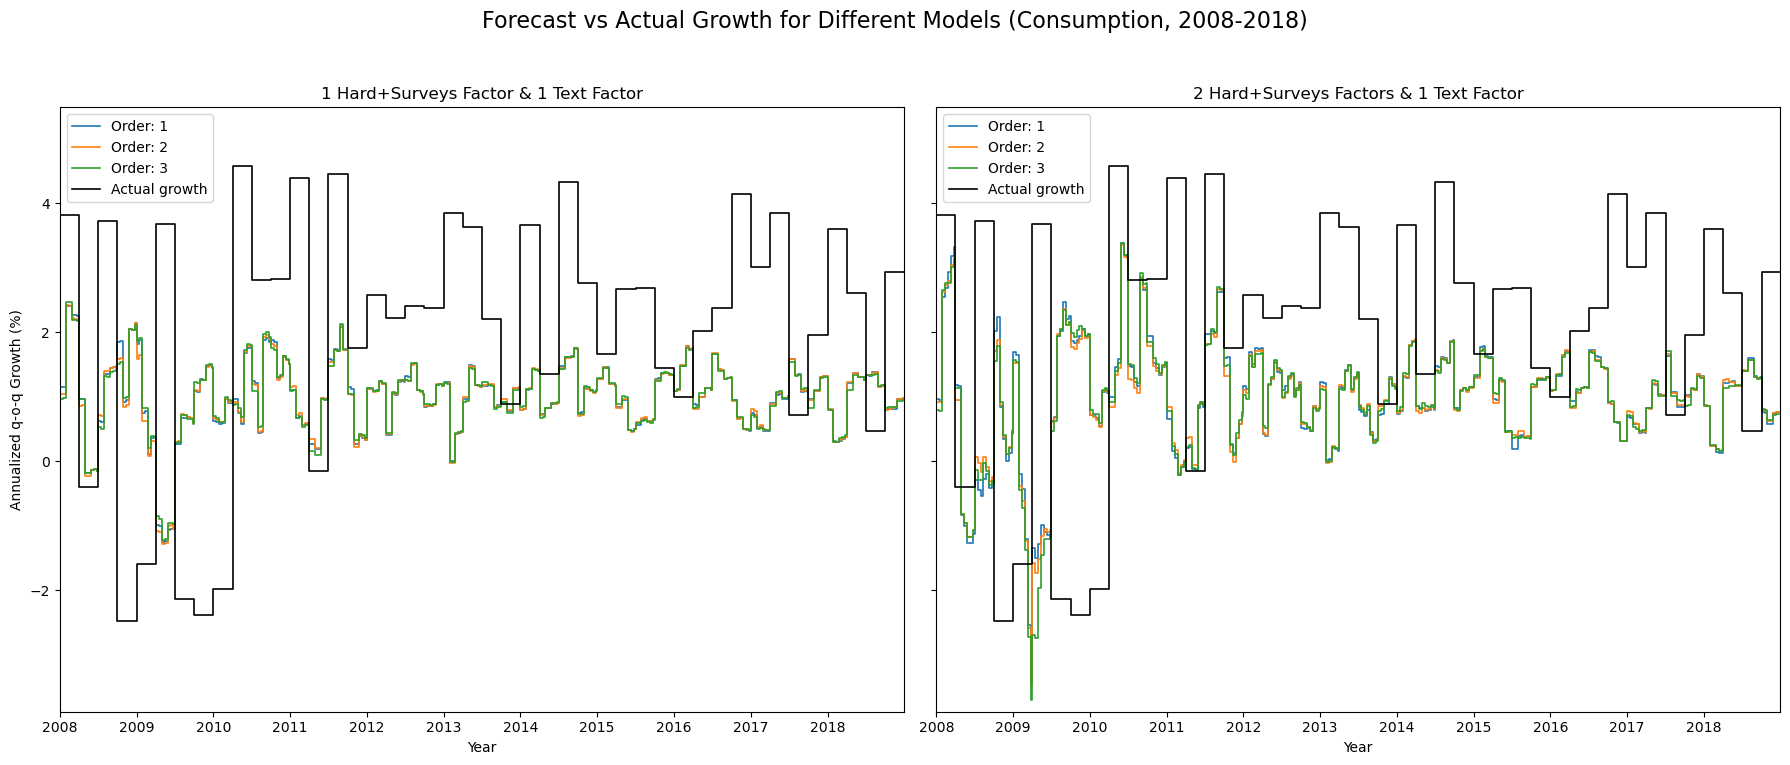

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


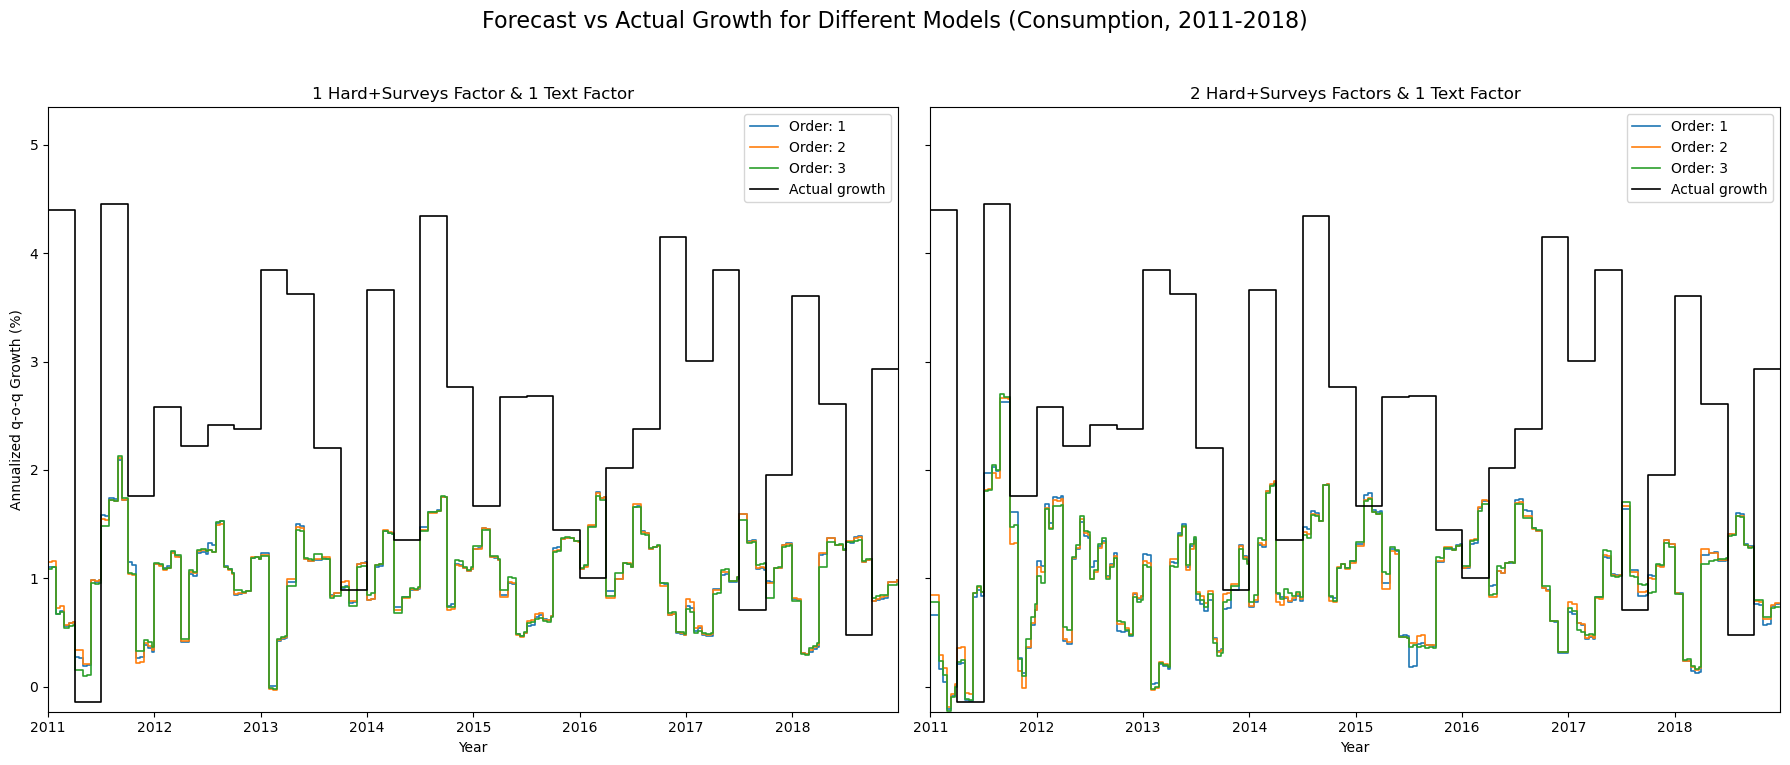

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()